In [4]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")
sys.path.append(module_path+"/experiments")

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [5]:
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAEDSprites, Classifier
from utils import latent_transversal, load_checkpoint, save_checkpoint
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae

In [7]:
whole_dataset = load_dsprites("../../datasets/dsprites.npz", False)
dataset = whole_dataset['imgs']
dataset = torch.from_numpy(dataset)

In [ ]:
#np.random.seed(2)
#torch.manual_seed(2)
#random.seed(2)

In [8]:
def compute_latent_gaussian_variance(model, dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    accumulator = torch.zeros(10)
    with torch.no_grad():
        for index, data in enumerate(loader):
            # shape of data is 64 x img_size
            _, _, logvar = model(data.float())
            accumulator = accumulator + logvar.div(2).exp().sum(0)
            if index % 1000 == 999:
                print('.', end='')
            del logvar
    return accumulator.div(len(dataset))

In [87]:
def latent_transversal_used_latents(model, image, stds):
    ret = []
    for latent_index in range(10):
        if stds[latent_index] < 0.5:
            transversal = latent_transversal(model, image, -3, 3, 5, latent_index)
            ret.append([latent_index, stds[latent_index], transversal])
    return ret

In [93]:
def latent_transversal_plot(model, image, stds, figsize=(8,8)):
    transversals = latent_transversal_used_latents(model, image, stds)
    transversals.sort(key=lambda x: x[1])
    rows = ['z{0}, {1:.2}'.format(transversal[0], transversal[1]) for transversal in transversals]
    fig, axes = plt.subplots(nrows=len(transversals), ncols=5, figsize=figsize)

    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(torch.sigmoid(transversals[i][2][j].detach()).view(64,64), cmap='Greys_r')
            col.set_yticks([])
            col.set_xticks([])
    plt.tight_layout()
    
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, size='large')
    
    plt.show()
        

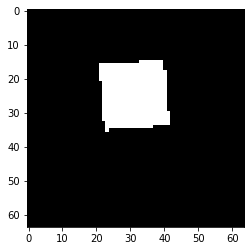

In [16]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()
plt.imshow(torch.sigmoid(original.detach()).view(64,64), cmap='Greys_r')
plt.show()

# Beta-VAE with beta=1

In [13]:
model_beta1 = torch.load("../trained_models/betavae_beta1_e50_n.dat")
model_beta1.cpu()
model_beta1.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [10]:
# see Beta VAE notebook for computation
latent_gaussian_std_beta1 = [0.0514, 0.9818, 0.1145, 0.9793, 0.0236, 0.1030, 0.0533, 0.0572, 0.0401,
        0.9770]

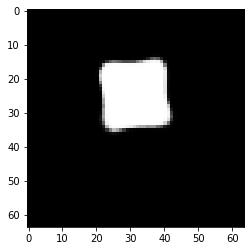

In [17]:
recon, mu, logvar = model_beta1(original)
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [22]:
transversals = latent_transversal_used_latents(model_beta1, original)

In [25]:
print(len(transversals))

7
5


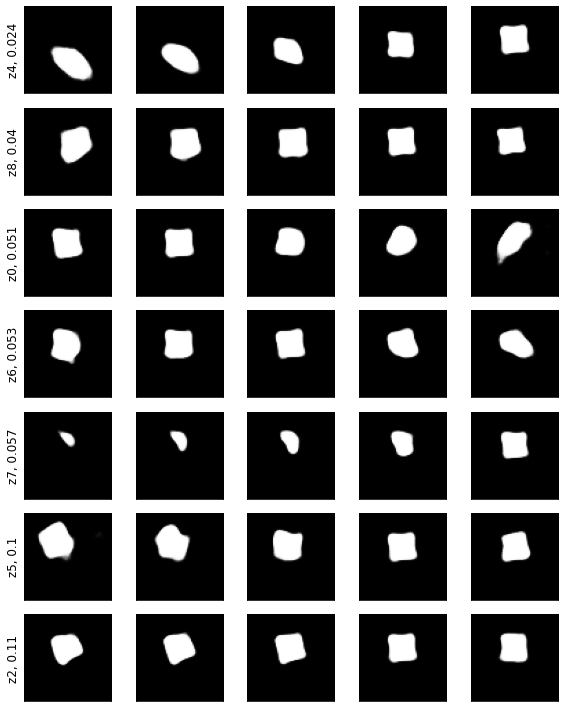

In [97]:
latent_transversal_plot(model_beta1, original, latent_gaussian_std_beta1, figsize=(8,10))

# Beta-VAE with beta=4

In [77]:
model_beta4 = torch.load("../trained_models/betavae_beta4_e50_n.dat")
model_beta4.cpu()
model_beta4.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [63]:
latent_gaussian_std_beta4 = compute_latent_gaussian_variance(model_beta4, dataset).to_list()

...........

In [72]:
latent_gaussian_std_beta4

[0.9948016405105591,
 0.9936812520027161,
 0.9945016503334045,
 0.2888352572917938,
 0.9963180422782898,
 0.9922326803207397,
 0.11154257506132126,
 0.04041251540184021,
 0.06364276260137558,
 0.18593019247055054]

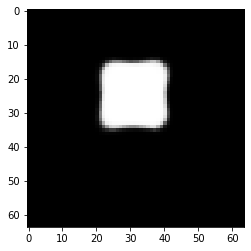

In [78]:
recon, mu, logvar = model_beta4(original)
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

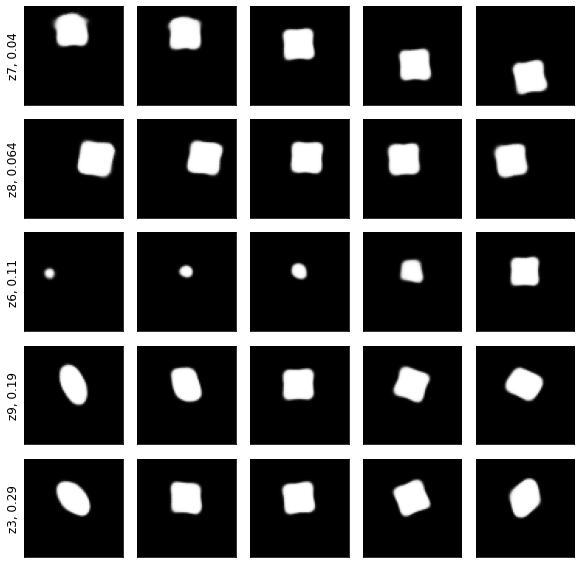

In [95]:
latent_transversal_plot(model_beta4, original, latent_gaussian_std_beta4, figsize=(8, 8))